In [14]:
import matplotlib.pyplot as plt
import matplotlib
import joblib
import cv2
import os
import torch 
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import random
from torchvision import models
from torchsummary import summary
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
matplotlib.style.use('ggplot')

def seed_everything(SEED=42):
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.benchmark = True 
SEED=42
seed_everything(SEED=SEED)

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [16]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import top_k_accuracy_score
from scipy import interp 
from itertools import cycle 
import seaborn as sn
import pandas as pd

from torchvision.datasets import Caltech101
trainset = Caltech101(root='./data', download=True, transform = transforms)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Files already downloaded and verified


In [17]:
train_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])
val_transform = transforms.Compose(
    [transforms.ToPILImage(),
     transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

batch_size = 16
epochs = 10

image_paths = list(paths.list_images('./data/caltech101/101_ObjectCategories'))
data = []
labels = []
for image_path in image_paths:
    label = image_path.split(os.path.sep)[-2]
    if label == 'BACKGROUND_Google':
        continue
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    data.append(image)
    labels.append(label)
data = np.array(data)
labels = np.array(labels)

lb = LabelBinarizer()
labels = lb.fit_transform(labels)
print(f"Total number of classes: {len(lb.classes_)}")

(x_train, x_test, y_train, y_test) = train_test_split(data, labels, 
                                                    test_size=0.2,  
                                                    stratify=labels,
                                                    random_state=42)

class ImageDataset(Dataset):
    def __init__(self, images, labels=None, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
         
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        data = self.X[i][:]
        
        if self.transforms:
            data = self.transforms(data)
            
        if self.y is not None:
            return (data, self.y[i])
        else:
            return data

train_data = ImageDataset(x_train, y_train, train_transform)
test_data = ImageDataset(x_test, y_test, val_transform)

print(f"x_train examples: {x_train.shape}\nx_test examples: {x_test.shape}")

Total number of classes: 101
x_train examples: (6941,)
x_test examples: (1736,)


In [18]:
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## **Plain 3-layer CNN**

In [19]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 10, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 3)
        self.conv3 = nn.Conv2d(20, 30, 3)
        self.fc = nn.Linear(20280, 101)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) 
        return self.fc(x)


net = Net().to(device)

In [ ]:
summary(net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 10, 222, 222]             280
         MaxPool2d-2         [-1, 10, 111, 111]               0
            Conv2d-3         [-1, 20, 109, 109]           1,820
         MaxPool2d-4           [-1, 20, 54, 54]               0
            Conv2d-5           [-1, 30, 52, 52]           5,430
         MaxPool2d-6           [-1, 30, 26, 26]               0
            Linear-7                  [-1, 101]       2,048,381
Total params: 2,055,911
Trainable params: 2,055,911
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 7.73
Params size (MB): 7.84
Estimated Total Size (MB): 16.15
----------------------------------------------------------------


In [20]:
optimizer = optim.Adam(net.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [21]:
def fit(model, dataloader, optimizer, criterion):
    print('Training')
    model.train()
    running_loss = 0.0
    running_correct = 0
    for i, data in tqdm(enumerate(dataloader),
                        total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, torch.max(target, 1)[1])
        running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        loss.backward()
        optimizer.step()
        
    loss = running_loss/len(dataloader.dataset)
    accuracy = 100. * running_correct/len(dataloader.dataset)
    
    print(f"Train Loss: {loss:.4f}, Train Acc: {accuracy:.2f}")
    
    return loss, accuracy

In [22]:
def validate(model, dataloader, optimizer, criterion):
    print('Validating')
    model.eval()
    running_loss = 0.0
    running_correct = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(dataloader),
                            total=int(len(test_data)/dataloader.batch_size)):
            data, target = data[0].to(device), data[1].to(device)
            outputs = model(data)
            loss = criterion(outputs, torch.max(target, 1)[1])
            
            running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            running_correct += (preds == torch.max(target, 1)[1]).sum().item()
        
        loss = running_loss/len(dataloader.dataset)
        accuracy = 100. * running_correct/len(dataloader.dataset)
        print(f'Test Loss: {loss:.4f}, Test Acc: {accuracy:.2f}')
        
        return loss, accuracy

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 8
Training


434it [00:24, 17.43it/s]


Train Loss: 0.1876, Train Acc: 37.82
Validating


109it [00:05, 18.50it/s]                         


Test Loss: 0.1380, Test Acc: 51.44
Epoch 2 of 8
Training


434it [00:24, 17.51it/s]


Train Loss: 0.0659, Train Acc: 74.11
Validating


109it [00:05, 18.42it/s]                         


Test Loss: 0.1487, Test Acc: 54.95
Epoch 3 of 8
Training


434it [00:24, 17.39it/s]


Train Loss: 0.0123, Train Acc: 95.12
Validating


109it [00:05, 18.52it/s]                         


Test Loss: 0.2324, Test Acc: 54.26
Epoch 4 of 8
Training


434it [00:25, 17.29it/s]


Train Loss: 0.0023, Train Acc: 99.03
Validating


109it [00:05, 18.31it/s]                         


Test Loss: 0.2615, Test Acc: 54.72
Epoch 5 of 8
Training


434it [00:25, 17.36it/s]


Train Loss: 0.0013, Train Acc: 99.51
Validating


109it [00:05, 18.59it/s]                         


Test Loss: 0.3147, Test Acc: 53.57
Epoch 6 of 8
Training


434it [00:24, 17.41it/s]                         


Train Loss: 0.0025, Train Acc: 99.02
Validating


109it [00:05, 18.68it/s]                         


Test Loss: 0.3140, Test Acc: 50.63
Epoch 7 of 8
Training


434it [00:24, 17.43it/s]


Train Loss: 0.0039, Train Acc: 98.24
Validating


109it [00:05, 18.47it/s]                         


Test Loss: 0.2988, Test Acc: 52.48
Epoch 8 of 8
Training


434it [00:25, 17.29it/s]


Train Loss: 0.0009, Train Acc: 99.65
Validating


109it [00:05, 18.38it/s]                         


Test Loss: 0.3238, Test Acc: 52.82
4.117601454257965 minutes


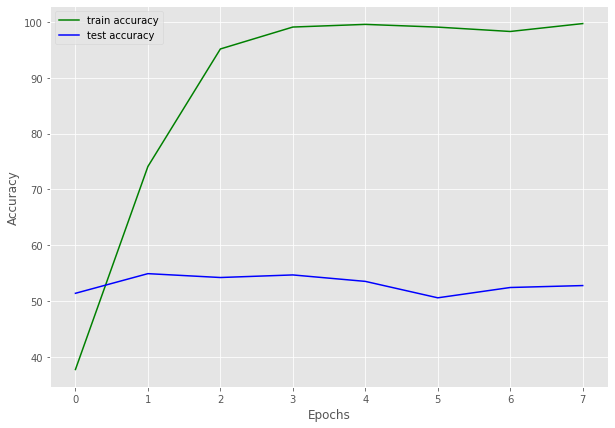

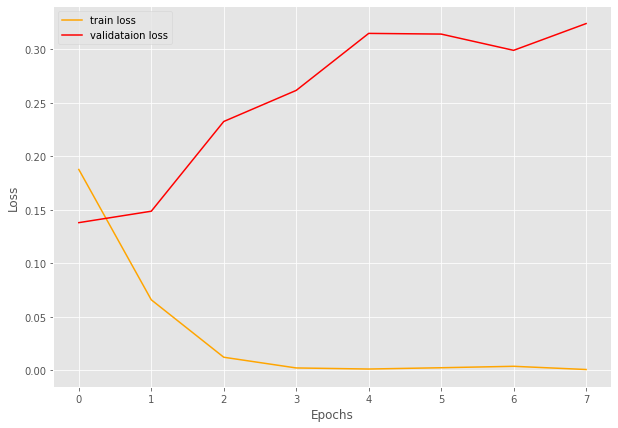

In [23]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

epochs = 8

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(net, trainloader, optimizer, criterion)
    val_epoch_loss, val_epoch_accuracy = validate(net, testloader, optimizer, criterion)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')
torch.save(net.state_dict(), f"./outputs/cnn-epochs{epochs}.pth")
torch.save(net, f"./data/outputs/cnn-model-epochs{epochs}.pth")

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./outputs/accuracy.png')

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./outputs/loss.png')

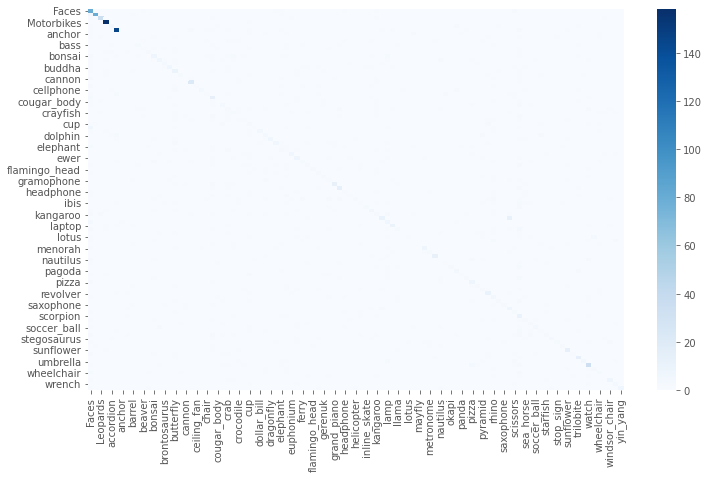

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in testloader:
        output = net(inputs.to(device)) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = lb.classes_

y_true_round = np.argmax(y_true,axis=1)

cf = confusion_matrix(y_true_round, y_pred)
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                   columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap = 'Blues', annot=False)
plt.savefig('confusion_matrix101_cnn.png')

In [25]:
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [26]:
report = classification_report(y_true_round, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Faces,0.519481,0.919540,0.663900,87.000000
Faces_easy,0.975610,0.919540,0.946746,87.000000
Leopards,0.875000,0.875000,0.875000,40.000000
Motorbikes,0.940476,0.987500,0.963415,160.000000
accordion,0.500000,0.454545,0.476190,11.000000
airplanes,0.912500,0.912500,0.912500,160.000000
anchor,0.000000,0.000000,0.000000,8.000000
ant,0.000000,0.000000,0.000000,8.000000
barrel,0.000000,0.000000,0.000000,9.000000
bass,0.500000,0.272727,0.352941,11.000000


In [34]:
import torch
model_net=torch.load("./outputs/cnn-mod-epochs8.pth")

X_test,Y_test = next(iter(testloader))
X_train,Y_train = next(iter(trainloader))
pred = model_net(X_test)
pred_ = pred.cpu().detach().numpy()
Y_test_ = Y_test.cpu().detach().numpy()

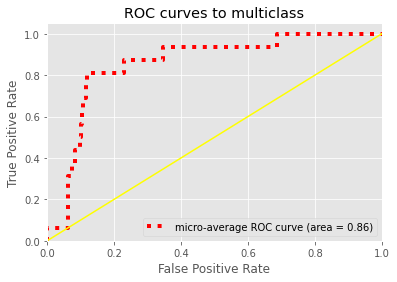

In [31]:
from sklearn.metrics import roc_curve, auc 
from scipy import interp 
from itertools import cycle 
 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
 
for i in range(101): 
    fpr[i], tpr[i], _ = roc_curve(Y_test_[:, i], pred_[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
 
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_.ravel(), pred_.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(101)])) 
 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(101): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
 
mean_tpr /= 101 

plt.figure() 
plt.plot( 
    fpr["micro"], 
    tpr["micro"], 
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), 
    color="red", 
    linestyle=":", 
    linewidth=4, 
)  

lw = 1.5 

plt.plot([0, 1], [0, 1], "-", lw=lw, color='yellow') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC curves to multiclass") 
plt.legend(loc="lower right") 
plt.show()

## **AUC-PRC curve**

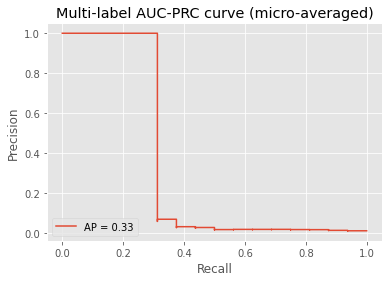

In [35]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

precision = dict()
recall = dict()
average_precision = dict()
for i in range(101):
    precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], pred_[:, i])
    average_precision[i] = average_precision_score(Y_test_[:, i], pred_[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test_.ravel(), pred_.ravel()
)
average_precision["micro"] = average_precision_score(Y_test_, pred_, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Multi-label AUC-PRC curve (micro-averaged)")

In [ ]:
y_pred = []
y_true = []
y_prob = []

for inputs, labels in testloader:
        output = model_net(inputs) 
        y_prob.extend(output)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

In [ ]:
probs = []
for i in range(len(y_prob)):
   probs.append(y_prob[i].detach().numpy())

prec = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1)
print('Top-1 error rate = ', (1-prec)*100, "%")

num_cor = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1, normalize=False)
print('Number of "correctly" classified samples = ', num_cor)

Top-1 error rate =  9.331797235023043 %
Number of "correctly" classified samples =  1574


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

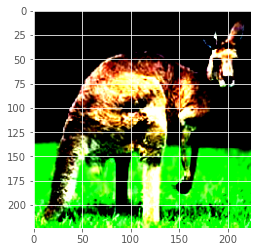

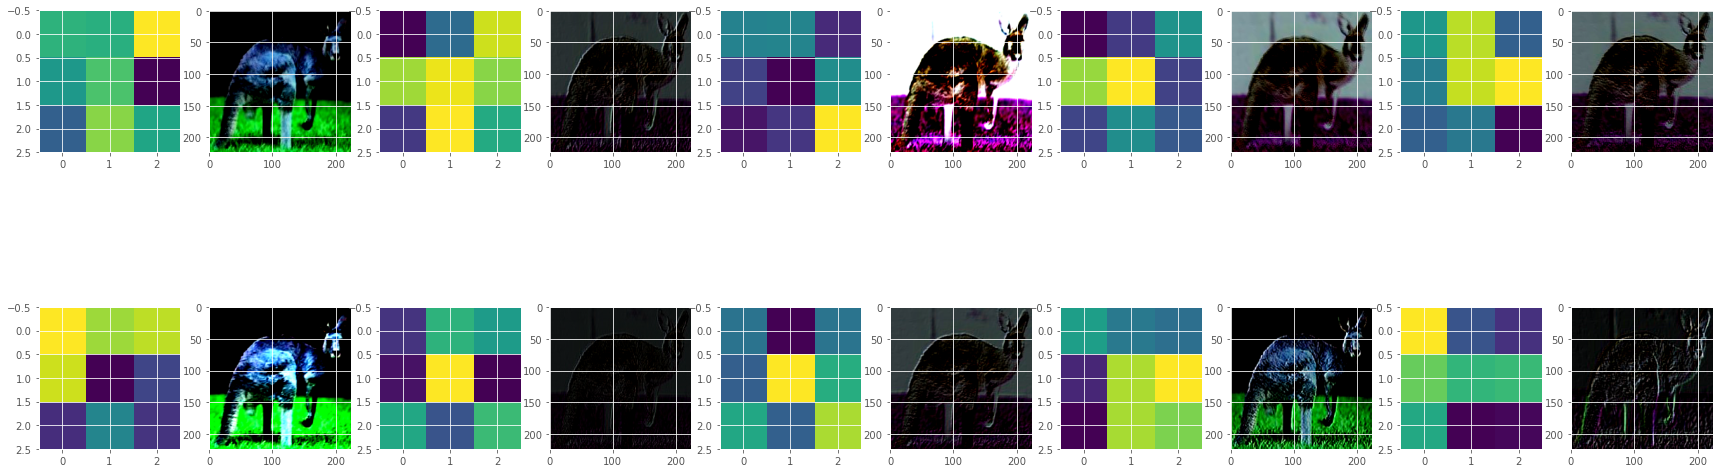

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

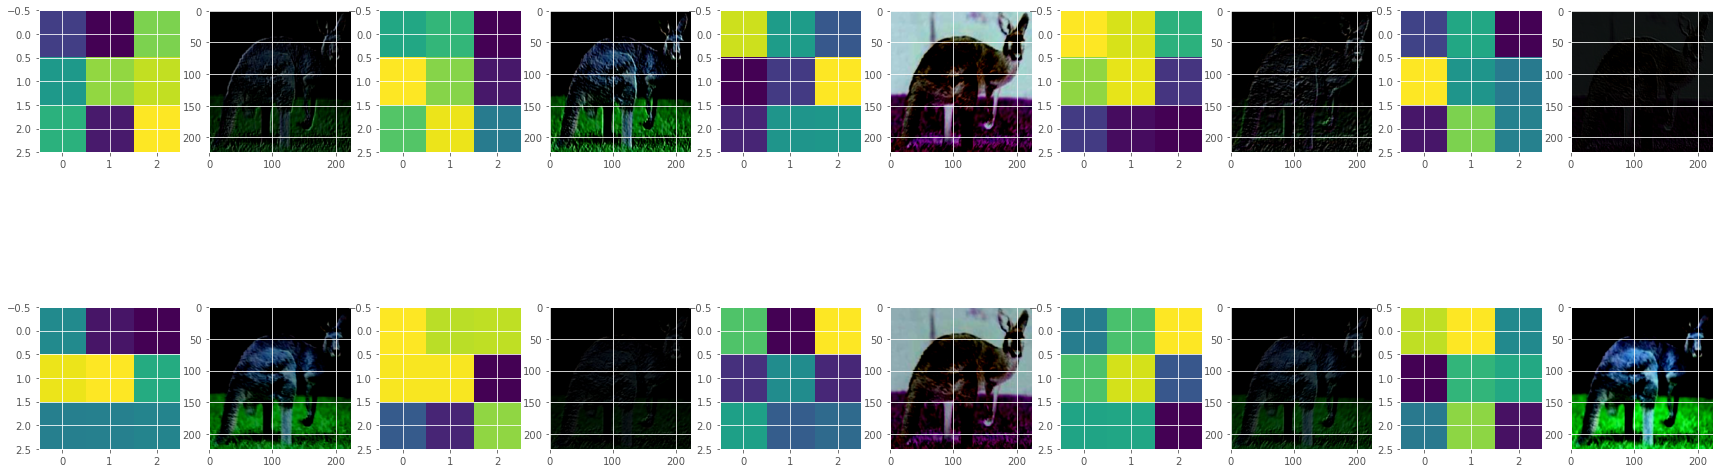

In [ ]:
import cv2
from PIL import Image

model_net.load_state_dict(torch.load('./outputs/cnn-epochs8.pth'))
model_net.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

idx = 3
img = np.squeeze(images[idx])

img = np.moveaxis(img, 0, -1)
plt.imshow(np.asarray(img))

weights = model_net.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

conv2_weights = model_net.conv2.weight.data
w = conv2_weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

## **Frozen pre-trained ResNet as feature extractor**

In [ ]:
wide_resnet = models.wide_resnet50_2(pretrained=True).to(device)

In [ ]:
summary(wide_resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5          [-1, 128, 56, 56]           8,192
       BatchNorm2d-6          [-1, 128, 56, 56]             256
              ReLU-7          [-1, 128, 56, 56]               0
            Conv2d-8          [-1, 128, 56, 56]         147,456
       BatchNorm2d-9          [-1, 128, 56, 56]             256
             ReLU-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          32,768
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [ ]:
for name, param in wide_resnet.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([128, 64, 1, 1]) False
layer1.0.bn1.weight torch.Size([128]) False
layer1.0.bn1.bias torch.Size([128]) False
layer1.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.0.bn2.weight torch.Size([128]) False
layer1.0.bn2.bias torch.Size([128]) False
layer1.0.conv3.weight torch.Size([256, 128, 1, 1]) False
layer1.0.bn3.weight torch.Size([256]) False
layer1.0.bn3.bias torch.Size([256]) False
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1]) False
layer1.0.downsample.1.weight torch.Size([256]) False
layer1.0.downsample.1.bias torch.Size([256]) False
layer1.1.conv1.weight torch.Size([128, 256, 1, 1]) False
layer1.1.bn1.weight torch.Size([128]) False
layer1.1.bn1.bias torch.Size([128]) False
layer1.1.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.1.bn2.weight torch.Size([128]) False
layer1.1.bn2.bias torch.Size([128]) False
layer1.1

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 10
Training


434it [01:46,  4.07it/s]


Train Loss: 0.0690, Train Acc: 76.21
Validating


109it [00:25,  4.19it/s]


Test Loss: 0.0259, Test Acc: 89.75
Epoch 2 of 10
Training


434it [01:47,  4.05it/s]


Train Loss: 0.0246, Train Acc: 90.25
Validating


109it [00:25,  4.20it/s]


Test Loss: 0.0226, Test Acc: 89.69
Epoch 3 of 10
Training


434it [01:47,  4.05it/s]


Train Loss: 0.0170, Train Acc: 92.90
Validating


109it [00:25,  4.19it/s]


Test Loss: 0.0175, Test Acc: 92.28
Epoch 4 of 10
Training


434it [01:47,  4.05it/s]


Train Loss: 0.0128, Train Acc: 94.48
Validating


109it [00:25,  4.19it/s]


Test Loss: 0.0196, Test Acc: 91.53
Epoch 5 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.0114, Train Acc: 94.84
Validating


109it [00:25,  4.20it/s]


Test Loss: 0.0170, Test Acc: 92.63
Epoch 6 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.0095, Train Acc: 95.69
Validating


109it [00:25,  4.21it/s]


Test Loss: 0.0167, Test Acc: 92.63
Epoch 7 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.0084, Train Acc: 96.18
Validating


109it [00:25,  4.20it/s]


Test Loss: 0.0168, Test Acc: 92.68
Epoch 8 of 10
Training


434it [01:46,  4.06it/s]


Train Loss: 0.0083, Train Acc: 96.07
Validating


109it [00:25,  4.22it/s]


Test Loss: 0.0169, Test Acc: 92.91
Epoch 9 of 10
Training


434it [01:47,  4.06it/s]


Train Loss: 0.0072, Train Acc: 96.18
Validating


109it [00:25,  4.20it/s]


Test Loss: 0.0178, Test Acc: 91.94
Epoch 10 of 10
Training


434it [01:47,  4.05it/s]


Train Loss: 0.0067, Train Acc: 96.83
Validating


109it [00:26,  4.18it/s]


Test Loss: 0.0188, Test Acc: 91.82
22.163081018129983 minutes


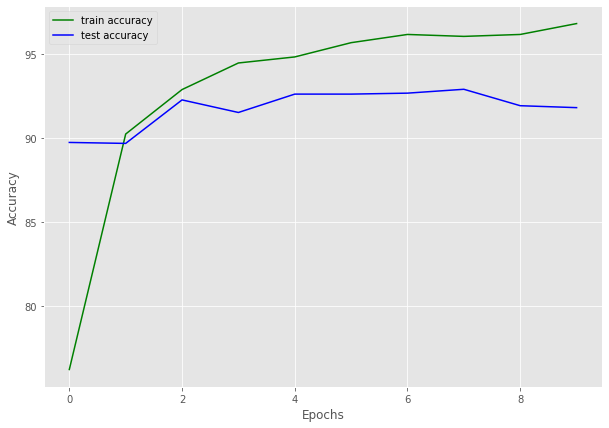

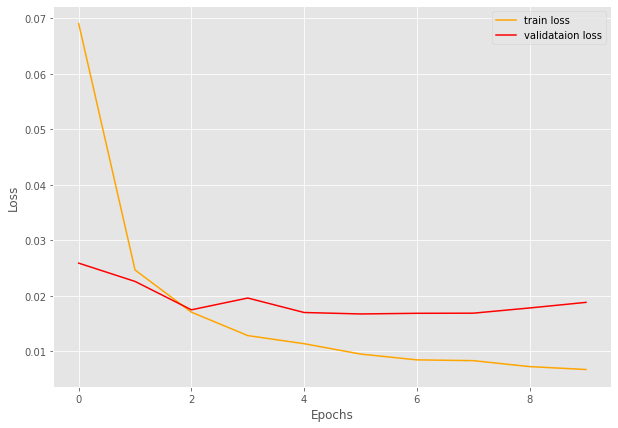

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

optimizer2 = optim.Adam(wide_resnet.parameters(), lr=1e-3)
criterion2 = nn.CrossEntropyLoss()

epochs = 10

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(wide_resnet, trainloader, optimizer2, criterion2)
    val_epoch_loss, val_epoch_accuracy = validate(wide_resnet, testloader, optimizer2, criterion2)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')
torch.save(wide_resnet, "./outputs/wide_resnet.pth")

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./outputs/wide_resnet-accuracy.png')

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./outputs/wide_resnet-loss.png')

In [ ]:
device = torch.device("cpu")

import torch
model_wide_resnet = torch.load("./outputs/wide_resnet.pth")

'df = pd.read_csv("df_wide_resnet.csv")\n#display(df)\nplt.figure(figsize = (12,7))\nsn.heatmap(df, cmap = \'Blues\', annot=False)\n#plt.savefig(\'confusion_matrix101_wide_resnet.png\')'

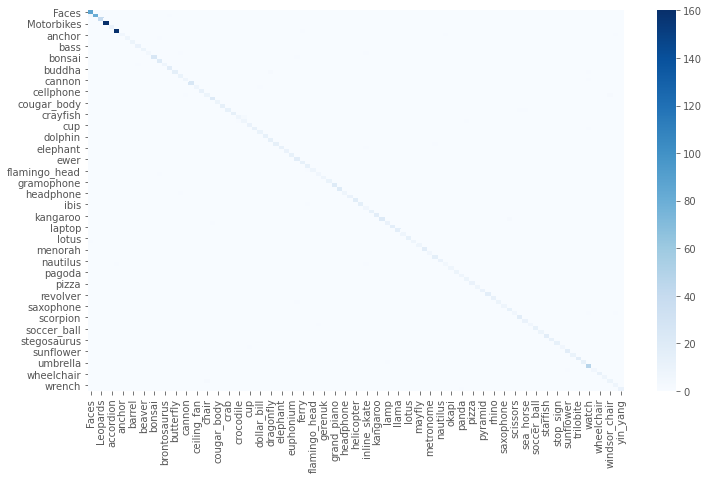

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in testloader:
        output = model_wide_resnet(inputs.to(device)) 

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

classes = lb.classes_

y_true_round = np.argmax(y_true,axis=1)

cf = confusion_matrix(y_true_round, y_pred)
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                   columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap = 'Blues', annot=False)


In [ ]:
from sklearn.metrics import PrecisionRecallDisplay

report = classification_report(y_true_round, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
df_report

,precision,recall,f1-score,support
Faces,0.935484,1.000000,0.966667,87.000000
Faces_easy,1.000000,0.931034,0.964286,87.000000
Leopards,1.000000,1.000000,1.000000,40.000000
Motorbikes,1.000000,1.000000,1.000000,160.000000
accordion,1.000000,1.000000,1.000000,11.000000
airplanes,0.993750,0.993750,0.993750,160.000000
anchor,1.000000,0.750000,0.857143,8.000000
ant,1.000000,0.875000,0.933333,8.000000
barrel,1.000000,1.000000,1.000000,9.000000
bass,0.916667,1.000000,0.956522,11.000000


In [ ]:
X_test,Y_test = next(iter(testloader))
X_train,Y_train = next(iter(trainloader))
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
pred = model_wide_resnet(X_test)
pred_ = pred.cpu().detach().numpy()
Y_test_ = Y_test.cpu().detach().numpy()

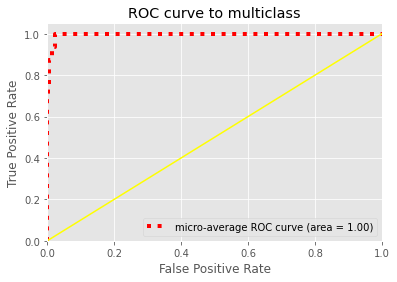

In [ ]:
from sklearn.metrics import roc_curve, auc 
from scipy import interp 
from itertools import cycle 
 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
 
for i in range(101): 
    fpr[i], tpr[i], _ = roc_curve(Y_test_[:, i], pred_[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
 
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_.ravel(), pred_.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(101)])) 
 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(101): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
 
mean_tpr /= 101 
 
plt.figure() 
plt.plot( 
    fpr["micro"], 
    tpr["micro"], 
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), 
    color="red", 
    linestyle=":", 
    linewidth=4, 
) 
 
lw = 1.5
 
plt.plot([0, 1], [0, 1], "-", lw=lw, color='yellow') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC curve to multiclass") 
plt.legend(loc="lower right") 
plt.show()

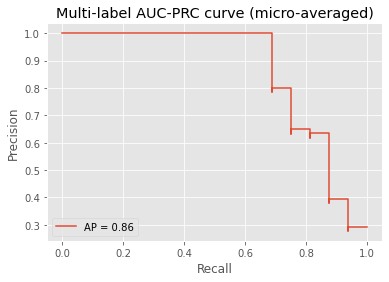

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

precision = dict()
recall = dict()
average_precision = dict()
for i in range(101):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_[:, i], pred_[:, i])
    average_precision[i] = average_precision_score(Y_test_[:, i], pred_[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test_.ravel(), pred_.ravel()
)
average_precision["micro"] = average_precision_score(Y_test_, pred_, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Multi-label AUC-PRC curve (micro-averaged)")

In [ ]:
y_pred = []
y_true = []
y_prob = []

for inputs, labels in testloader:
        output = model_wide_resnet(inputs.to(device)) 
        y_prob.extend(output)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

In [ ]:
probs = []
for i in range(len(y_prob)):
   probs.append(y_prob[i].cpu().detach().numpy())

prec = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1)
print('Top-1 error rate = ', (1-prec)*100, "%")

num_cor = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1, normalize=False)
print('Number of "correctly" classified samples = ', num_cor)

Top-1 error rate =  2.995391705069128 %
Number of "correctly" classified samples =  1684


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

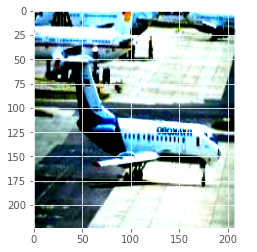

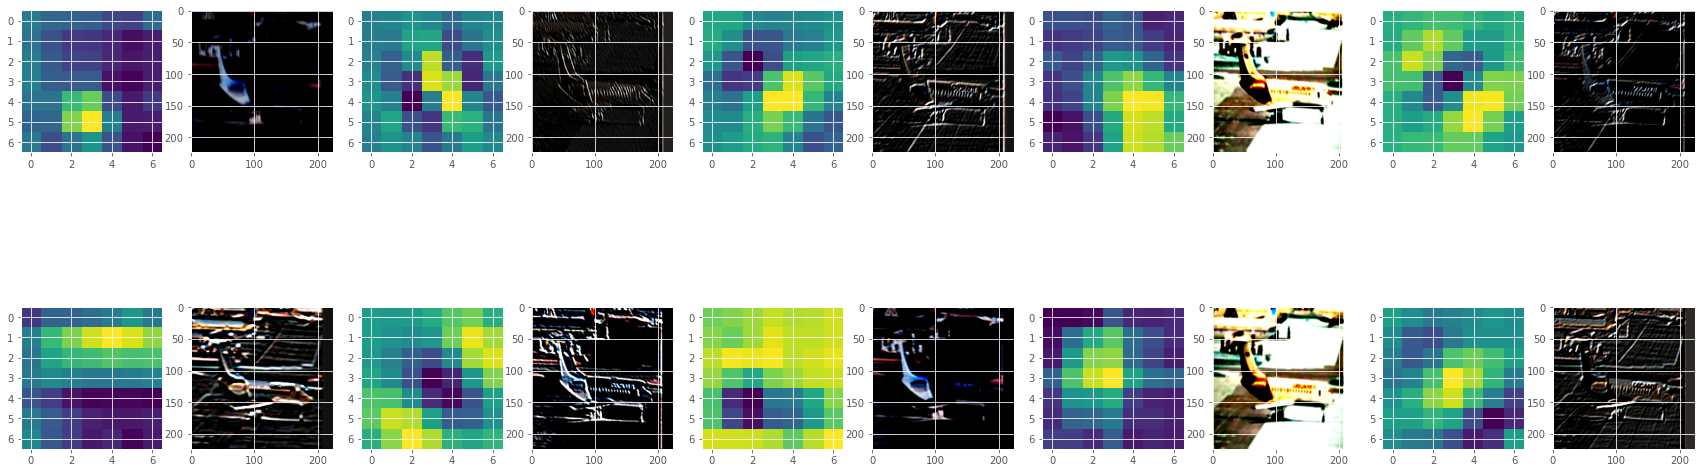

In [ ]:
import cv2
from PIL import Image

model_wide_resnet.load_state_dict(torch.load('./outputs/wide_resnet-epochs10.pth'))
model_wide_resnet.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

idx = 3
img = np.squeeze(images[idx])

img = np.moveaxis(img, 0, -1)
plt.imshow(np.asarray(img))

weights = model_wide_resnet.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

## **Fine-tuned pre-trained ResNet**

In [ ]:
wide_resnet_ft = models.wide_resnet50_2(pretrained=True).to(device)

ct = 0
for child in wide_resnet_ft.children():
  ct += 1
  if ct < 8:
      for param in child.parameters():
          param.requires_grad = False
  else:
      for param in child.parameters():
          param.requires_grad = True

num_ftrs = wide_resnet_ft.fc.in_features
wide_resnet_ft.fc = nn.Linear(num_ftrs, 101)
wide_resnet_ft = wide_resnet_ft.to(device)

for name, param in wide_resnet_ft.named_parameters():
    print(name, param.size(), param.requires_grad)

conv1.weight torch.Size([64, 3, 7, 7]) False
bn1.weight torch.Size([64]) False
bn1.bias torch.Size([64]) False
layer1.0.conv1.weight torch.Size([128, 64, 1, 1]) False
layer1.0.bn1.weight torch.Size([128]) False
layer1.0.bn1.bias torch.Size([128]) False
layer1.0.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.0.bn2.weight torch.Size([128]) False
layer1.0.bn2.bias torch.Size([128]) False
layer1.0.conv3.weight torch.Size([256, 128, 1, 1]) False
layer1.0.bn3.weight torch.Size([256]) False
layer1.0.bn3.bias torch.Size([256]) False
layer1.0.downsample.0.weight torch.Size([256, 64, 1, 1]) False
layer1.0.downsample.1.weight torch.Size([256]) False
layer1.0.downsample.1.bias torch.Size([256]) False
layer1.1.conv1.weight torch.Size([128, 256, 1, 1]) False
layer1.1.bn1.weight torch.Size([128]) False
layer1.1.bn1.bias torch.Size([128]) False
layer1.1.conv2.weight torch.Size([128, 128, 3, 3]) False
layer1.1.bn2.weight torch.Size([128]) False
layer1.1.bn2.bias torch.Size([128]) False
layer1.1

Training on 6941 examples, validating on 1736 examples...
Epoch 1 of 5
Training


434it [02:40,  2.71it/s]


Train Loss: 0.1681, Train Acc: 39.04
Validating


109it [00:30,  3.54it/s]


Test Loss: 0.0905, Test Acc: 60.60
Epoch 2 of 5
Training


434it [02:27,  2.95it/s]


Train Loss: 0.0687, Train Acc: 68.74
Validating


109it [00:27,  3.98it/s]


Test Loss: 0.0431, Test Acc: 81.05
Epoch 3 of 5
Training


434it [02:27,  2.95it/s]


Train Loss: 0.0324, Train Acc: 84.84
Validating


109it [00:27,  3.99it/s]


Test Loss: 0.0296, Test Acc: 87.79
Epoch 4 of 5
Training


434it [02:27,  2.95it/s]


Train Loss: 0.0184, Train Acc: 90.89
Validating


109it [00:27,  3.98it/s]


Test Loss: 0.0191, Test Acc: 91.42
Epoch 5 of 5
Training


434it [02:27,  2.95it/s]


Train Loss: 0.0117, Train Acc: 94.47
Validating


109it [00:27,  3.99it/s]


Test Loss: 0.0228, Test Acc: 89.63
14.812965842088063 minutes


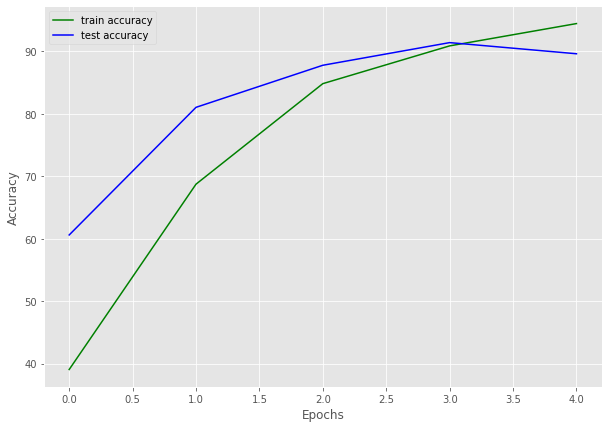

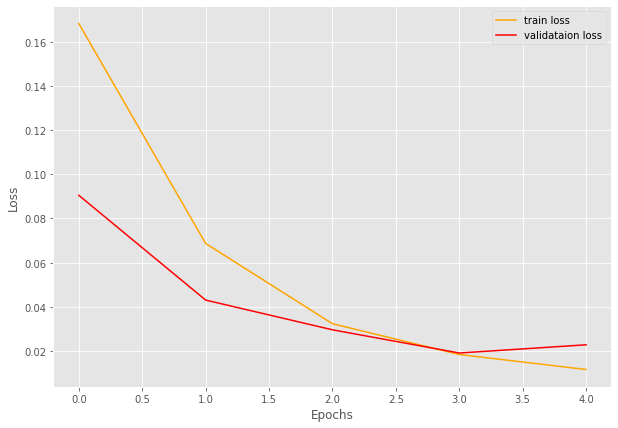

In [ ]:
epochs = 5
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []

optimizer2 = optim.Adam(wide_resnet_ft.parameters(), lr=1e-3)
criterion2 = nn.CrossEntropyLoss()

print(f"Training on {len(train_data)} examples, validating on {len(test_data)} examples...")
start = time.time()

for epoch in range(epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss, train_epoch_accuracy = fit(wide_resnet_ft,
                                                 trainloader,
                                                 optimizer2,
                                                 criterion2)
    val_epoch_loss, val_epoch_accuracy = validate(wide_resnet_ft,
                                                  testloader,
                                                  optimizer2,
                                                  criterion2)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

end = time.time()
print((end-start)/60, 'minutes')

torch.save(wide_resnet_ft, f"./outputs/wide_resnet_ft-epochs.pth")

plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='test accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('./outputs/wide_resnet_ft-accuracy.png')

plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('./outputs/wide_resnet_ft-loss.png')

In [ ]:
import torch
model_wide_resnet_ft = torch.load("./outputs/wide_resnet_ft_epochs.pth")

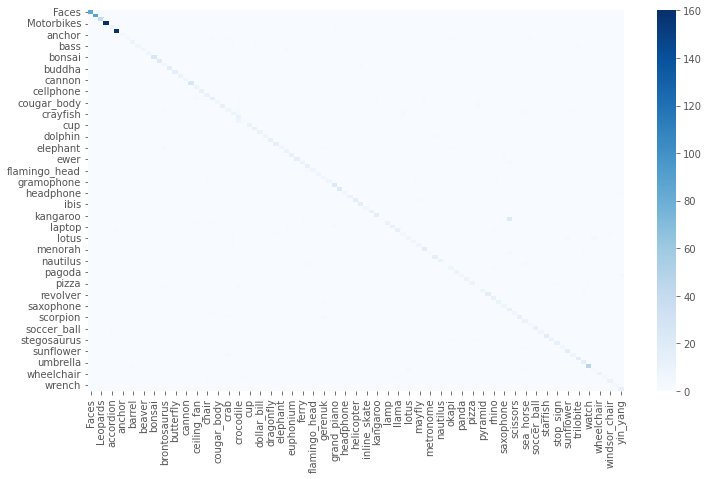

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

y_pred = []
y_true = []

for inputs, labels in testloader:
        output = model_wide_resnet_ft(inputs.to(device))

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 

classes = lb.classes_


y_true_round = np.argmax(y_true,axis=1)

cf = confusion_matrix(y_true_round, y_pred)
df_cm = pd.DataFrame(cf, index = [i for i in classes],
                   columns = [i for i in classes])

plt.figure(figsize = (12,7))
sn.heatmap(df_cm, cmap = 'Blues', annot=False)
plt.savefig('confusion_matrix101_wide_resnet_ft.png')

In [ ]:
report = classification_report(y_true_round, y_pred, target_names=classes, output_dict=True)
df_report = pd.DataFrame(report).transpose()
display(df_report)

,precision,recall,f1-score,support
Faces,1.000000,0.977011,0.988372,87.000000
Faces_easy,0.977528,1.000000,0.988636,87.000000
Leopards,1.000000,1.000000,1.000000,40.000000
Motorbikes,1.000000,1.000000,1.000000,160.000000
accordion,0.833333,0.909091,0.869565,11.000000
airplanes,0.993750,0.993750,0.993750,160.000000
anchor,1.000000,0.625000,0.769231,8.000000
ant,0.666667,0.500000,0.571429,8.000000
barrel,0.900000,1.000000,0.947368,9.000000
bass,1.000000,0.727273,0.842105,11.000000


In [ ]:
X_test,Y_test = next(iter(testloader))
X_train,Y_train = next(iter(trainloader))
X_train = X_train.to(device)
Y_train = Y_train.to(device)
X_test = X_test.to(device)
Y_test = Y_test.to(device)
pred = model_wide_resnet_ft(X_test)
pred_ = pred.cpu().detach().numpy()
Y_test_ = Y_test.cpu().detach().numpy()

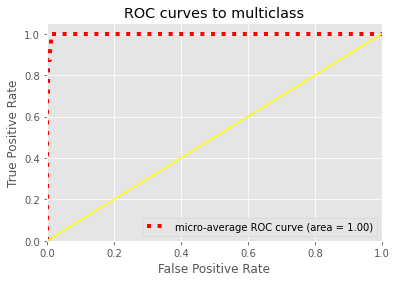

In [ ]:
from sklearn.metrics import roc_curve, auc 
from scipy import interp 
from itertools import cycle 
 
fpr = dict() 
tpr = dict() 
roc_auc = dict() 
 
for i in range(101): 
    fpr[i], tpr[i], _ = roc_curve(Y_test_[:, i], pred_[:, i]) 
    roc_auc[i] = auc(fpr[i], tpr[i]) 
 
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_.ravel(), pred_.ravel()) 
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"]) 
 
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(101)])) 
 
mean_tpr = np.zeros_like(all_fpr) 
for i in range(101): 
    mean_tpr += interp(all_fpr, fpr[i], tpr[i]) 
 
mean_tpr /= 101 
 
fpr["macro"] = all_fpr 
tpr["macro"] = mean_tpr 
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"]) 
 
plt.figure() 
plt.plot( 
    fpr["micro"], 
    tpr["micro"], 
    label="micro-average ROC curve (area = {0:0.2f})".format(roc_auc["micro"]), 
    color="red", 
    linestyle=":", 
    linewidth=4, 
) 
 
lw = 1.5 

plt.plot([0, 1], [0, 1], "-", lw=lw, color='yellow') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate") 
plt.title("ROC curves to multiclass") 
plt.legend(loc="lower right") 
plt.show()

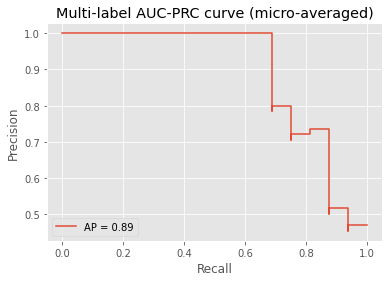

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import PrecisionRecallDisplay

precision = dict()
recall = dict()
average_precision = dict()
for i in range(101):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_[:, i], pred_[:, i])
    average_precision[i] = average_precision_score(Y_test_[:, i], pred_[:, i])

precision["micro"], recall["micro"], _ = precision_recall_curve(
    Y_test_.ravel(), pred_.ravel()
)
average_precision["micro"] = average_precision_score(Y_test_, pred_, average="micro")

display = PrecisionRecallDisplay(
    recall=recall["micro"],
    precision=precision["micro"],
    average_precision=average_precision["micro"],
)
display.plot()
_ = display.ax_.set_title("Multi-label AUC-PRC curve (micro-averaged)")

In [ ]:
import torch
model_wide_resnet_ft = torch.load("./outputs/wide_resnet_ft_epochs.pth", map_location='cpu')
y_pred = []
y_true = []
y_prob = []

for inputs, labels in testloader:
        output = model_wide_resnet_ft(inputs).cpu() # Feed Network
        y_prob.extend(output)

        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output)
        
        labels = labels.data.cpu().numpy()
        y_true.extend(labels)

In [ ]:
probs = []
for i in range(len(y_prob)):
   probs.append(y_prob[i].cpu().detach().numpy())

prec = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1)
print('Top-1 error rate = ', (1-prec)*100, "%")

num_cor = top_k_accuracy_score(np.argmax(y_true, axis=1), probs, k=1, normalize=False)
print('Number of "correctly" classified samples = ', num_cor)

Top-1 error rate =  4.665898617511521 %
Number of "correctly" classified samples =  1655


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

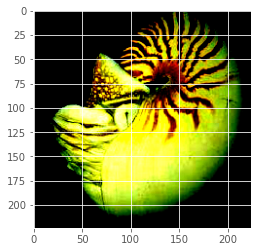

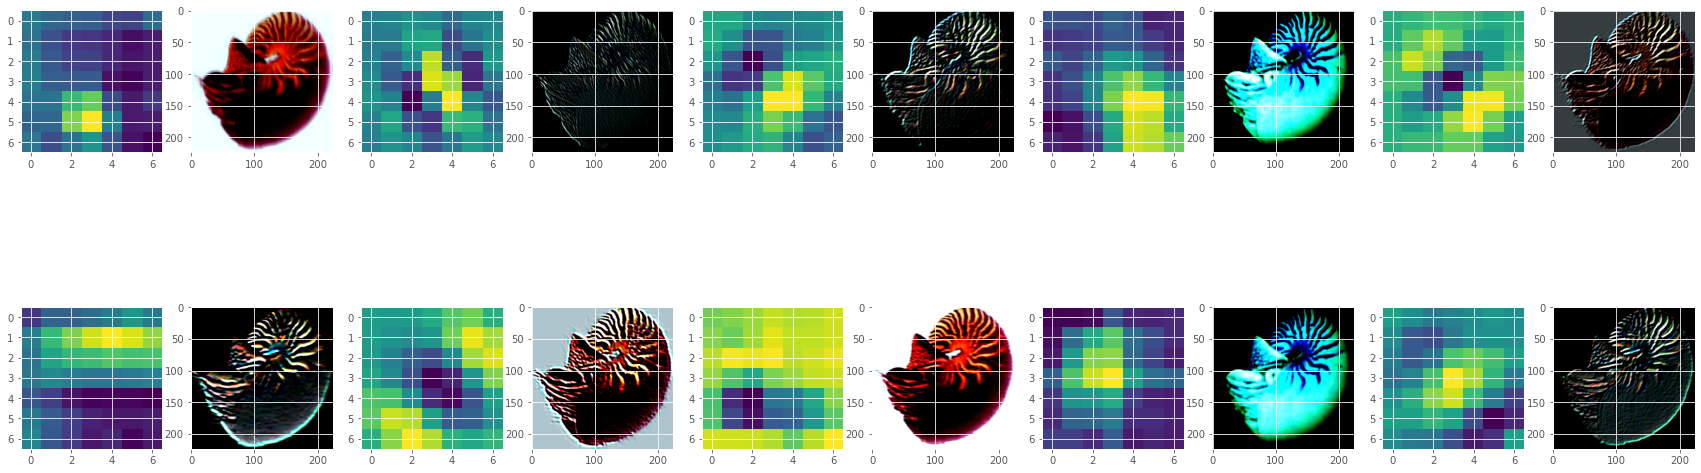

In [ ]:
import cv2
from PIL import Image

model_wide_resnet_ft.load_state_dict(torch.load('./outputs/wide_resnet_ft-epochs5.pth'))
model_wide_resnet_ft.eval()

dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.numpy()

idx = 3
img = np.squeeze(images[idx])

img = np.moveaxis(img, 0, -1)
plt.imshow(np.asarray(img))

weights = model_wide_resnet_ft.conv1.weight.data
w = weights.cpu().numpy()
fig=plt.figure(figsize=(30, 10))
columns = 10
rows = 2

for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0])
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(cv2.cvtColor(c, cv2.COLOR_BGR2RGB))
plt.show()

# RESULTS
### 3-layer CNN - 9.3% 
### Frozen pre-trained ResNet as feature extractor - 2.9%
### Fine-tuned pre-trained ResNet - 4.6%